In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
import peakutils
from sklearn.preprocessing import normalize

Text(0, 0.5, 'Raman Intensity (cps)')

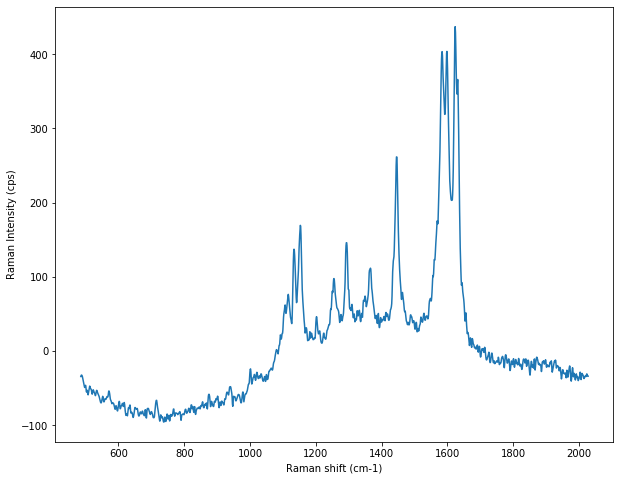

In [18]:
# Plot Raman spectrum
df1 = pd.read_csv('PP_Probe/PP_Probe_1.CSV', index_col=0, header=None)
df1 = df1.iloc[400:2000]
wavelength = df1.index

sns.lineplot(y=df1[1],x=wavelength)
plt.xlabel('Raman shift (cm-1)')
plt.ylabel('Raman Intensity (cps)')

In [19]:
# Define a function to smooth data by moving average
def smooth(data):
    rolling_average = data.rolling(window=10).mean()
    smoothed_data = rolling_average.drop(rolling_average[(rolling_average.index >= 2000 )| (rolling_average.index <= 500)].index)
    return smoothed_data
# Define a function to correct baseline by polynomial fitting method
def baseline_correction(data):
    baseline_value = peakutils.baseline(data)
    baseline_corrected=data-baseline_value
    return baseline_corrected

In [20]:
data = []
folder_path = ['Ecoli','PP_Probe','PP_Probe_Ecoli','Probe']
for i in folder_path:
    files = glob.glob(os.path.join(i, '*.CSV')) 
    file_name = i
    for f in files:
        df = pd.read_csv(f, index_col=0, names=[file_name])
        df = df.iloc[400:2000]
        df.index = wavelength
        data.append(df)
        
all_data = pd.concat(data, axis=1) 
col = len(all_data.columns)

frames=[]
for i in range(0, col):
    data=smooth(all_data.iloc[:,[i]])
    data=baseline_correction(data)
    data=data.transpose()
    frames.append(data)
denoised_all = pd.concat(frames)

col = denoised_all.columns
index = denoised_all.index

In [21]:
# Vector normalization
Y = denoised_all.index
X_norm = normalize(denoised_all, norm='max')

X_norm_file = pd.DataFrame(X_norm)
X_norm_file.columns = col
X_norm_file.index = index
X_norm_file.to_csv('all_denoised_data.csv')

In [22]:
# Encoding categorical data values
from sklearn.preprocessing import LabelEncoder
labelencoder_Y = LabelEncoder()
Y = labelencoder_Y.fit_transform(Y)
Y

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [23]:
# Split spectral data
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_norm, Y, test_size = 0.3, random_state=0)
Y_train

array([3, 3, 1, 0, 3, 2, 1, 1, 3, 2, 0, 1, 1, 1, 3, 2, 2, 1, 1, 1, 2, 1,
       1, 1, 2, 2, 0, 1, 3, 1, 2, 1, 1, 2, 2, 1, 1, 1, 0, 3, 1, 3, 1, 2,
       2, 2, 2, 2, 1, 3, 2, 1, 1, 3, 3, 2, 2, 2])

In [24]:
from sklearn.decomposition import PCA
#Fit the spectral data and extract the explained variance ratio
pca1 = PCA(n_components=10)
trained_pca = pca1.fit_transform(X_norm)
var1 = pca1.explained_variance_ratio_
var = pd.DataFrame(var1, columns=['explained'])
var['cumulative'] = np.cumsum(var1)
var

,explained,cumulative
0,0.416039,0.416039
1,0.306904,0.722943
2,0.134261,0.857204
3,0.040676,0.897880
4,0.024444,0.922325
5,0.016429,0.938754
6,0.011384,0.950138
7,0.008881,0.959019
8,0.006188,0.965207
9,0.005575,0.970783


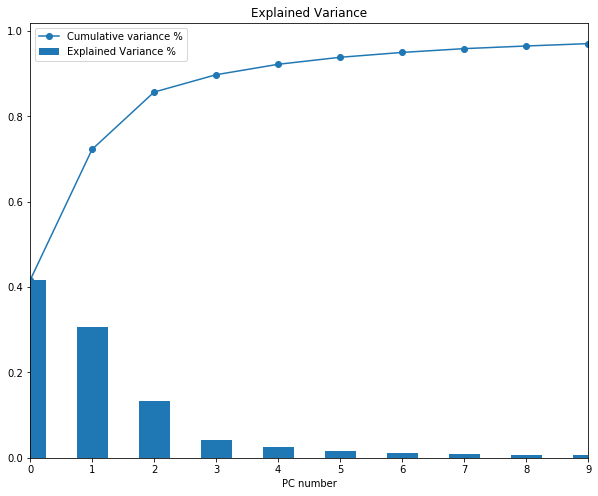

In [25]:
fig, ax = plt.subplots()
var['explained'].plot(kind='bar', label="Explained Variance %")
var['cumulative'].plot(kind='line',marker='o', label = 'Cumulative variance %')
ax.set_xlabel("PC number")
ax.set_title('Explained Variance')

plt.legend()
plt.show()

In [26]:
pca_result = pd.DataFrame(data=trained_pca)
pca_result['Cluster']=Y
pca_result

,0,1,2,3,4,5,6,7,8,9,Cluster
0,2.750606,6.708653,2.035519,0.027580,0.200156,-0.328926,0.002527,0.145414,0.273324,-0.221724,0
1,2.880403,6.707477,2.187349,0.020169,-0.462408,-0.052470,0.180700,0.035584,0.046455,0.112663,0
2,3.198584,4.747378,3.681284,0.930403,-0.480932,-0.069914,0.287635,0.527711,-0.712614,1.359838,0
3,2.772160,7.160679,1.006174,-0.374367,-0.385893,-0.173236,-0.099917,-0.247301,0.022771,-0.859271,0
4,2.859282,6.830731,1.204906,-0.144120,-0.122641,-0.327388,-0.080846,-0.119225,0.038876,-0.634614,0
...,...,...,...,...,...,...,...,...,...,...,...
78,2.938787,-0.181077,-1.476990,-0.173446,0.061112,0.375107,-0.110025,-0.296224,0.103914,0.192968,3
79,3.096935,-0.716137,-0.705213,-0.057715,0.321756,-0.053068,0.041574,-0.174742,-0.085550,0.043975,3
80,3.038993,-0.597741,-0.625738,-0.131479,0.328013,0.320054,-0.091870,-0.186872,0.235263,0.184636,3
81,2.977637,-0.315555,-1.557564,-0.088374,0.203000,0.146707,-0.002835,-0.230944,0.003739,0.111862,3


Text(0, 0.5, 'PC1')

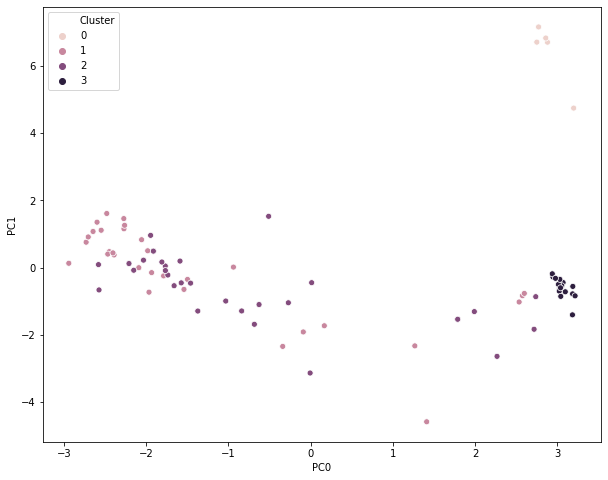

In [27]:
p = sns.scatterplot(x=pca_result[0], y=pca_result[1], hue=pca_result['Cluster'])
plt.xlabel('PC0')
plt.ylabel('PC1')

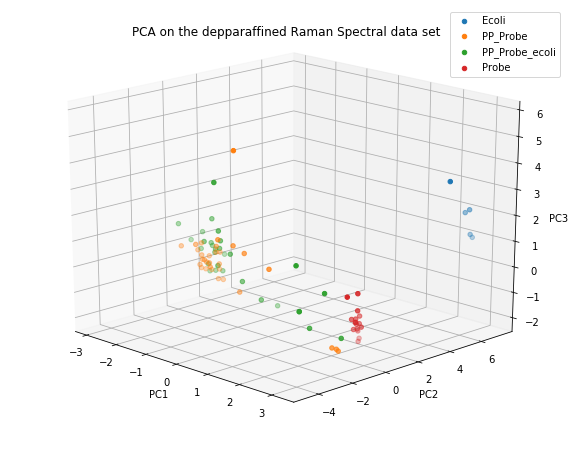

In [28]:
# 3D

from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = 10, 8
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

pca_ecoli = pca_result.loc[pca_result['Cluster']==0]
x1 = pca_ecoli[0]
y1 = pca_ecoli[1]
z1 = pca_ecoli[2]
pca_pp_probe = pca_result.loc[pca_result['Cluster']==1]
x2 = pca_pp_probe[0]
y2 = pca_pp_probe[1]
z2 = pca_pp_probe[2]
pca_pp_probe_ecoli = pca_result.loc[pca_result['Cluster']==2]
x3 = pca_pp_probe_ecoli[0]
y3 = pca_pp_probe_ecoli[1]
z3 = pca_pp_probe_ecoli[2]
pca_probe = pca_result.loc[pca_result['Cluster']==3]
x4 = pca_probe[0]
y4 = pca_probe[1]
z4 = pca_probe[2]

ax.scatter(x1,y1,z1, label='Ecoli')
ax.scatter(x2,y2,z2, label='PP_Probe')
ax.scatter(x3,y3,z3, label='PP_Probe_ecoli')
ax.scatter(x4,y4,z4, label='Probe')

# label the axes
ax.legend()
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA on the depparaffined Raman Spectral data set")
ax.view_init(elev=20., azim=-45)

plt.show()

In [29]:
# Split pca data
x = pca_result.drop(columns='Cluster')
y = pca_result['Cluster']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=0)


In [30]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}    

grid = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=param_grid, verbose=3) 
  
# fitting the model for grid search 
grid.fit(x_train, y_train) 


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] C=1, gamma=1 ....................................................
[CV] ........................ C=1, gamma=1, score=0.571, total=   0.0s
[CV] C=1, gamma=1 ....................................................
[CV] ........................ C=1, gamma=1, score=0.579, total=   0.0s
[CV] C=1, gamma=1 ....................................................
[CV] ........................ C=1, gamma=1, score=0.833, total=   0.0s
[CV] C=1, gamma=0.1 ..................................................
[CV] ...................... C=1, gamma=0.1, score=0.714, total=   0.0s
[CV] C=1, gamma=0.1 ..................................................
[CV] ...................... C=1, gamma=0.1, score=0.684, total=   0.0s
[CV] C=1, gamma=0.1 ..................................................
[CV] ...................... C=1, gamma=0.1, score=0.833, total=   0.0s
[CV] C=1, gamma=0.01 .................................................
[CV] ...........

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.2s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [31]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 100, 'gamma': 0.01}
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [32]:
print(grid.score(x_test, y_test))

0.88


0.68


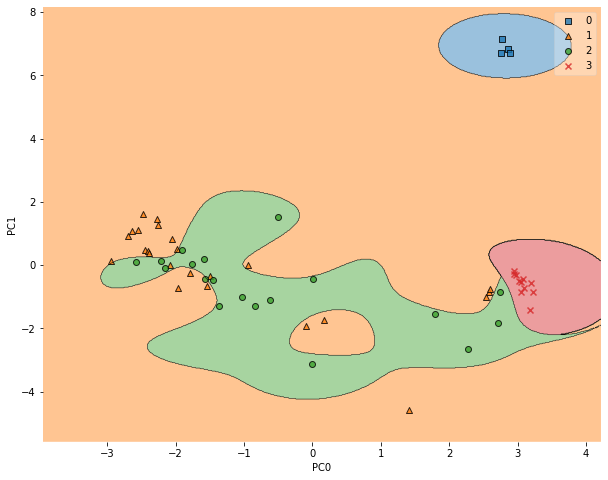

In [33]:
from mlxtend.plotting import plot_decision_regions
x_train_2 = np.array(x_train.iloc[:,0:2])
x_test_2 = np.array(x_test.iloc[:,0:2])
svm = SVC(kernel='rbf', C=1000, gamma=1)
svm.fit(x_train_2, y_train)
print(svm.score(x_test_2,y_test))
# Visualize the decision boundaries for PC1 and PC2
plot_decision_regions(np.array(x_train_2), np.array(y_train), clf=svm)
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.show()